# THE PLAN

1. Construct FFDs in log-energy vs log-freq space as func of sp. type
    1.5 Create a broken power law model and fit on FFDs
    Deliverable: Location in freq space of power law breaks as fn of spec. type
2. Identify frequency ranges in which power-law break is not recovered, i.e. freq gaps (cadence opsim)
    Deliverable: MAF that ingests cadence opsim and returns freq gaps per spec. type
3. Identify energy range, therefore distances at which break is recovered, i.e. find frequency-energy box around break 
4. Develop metric for flare science based on stellar parameters (sp. type, distance) and telescope cadence

Reminder: SEND Dr Gizis email re: meeting 

In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools


#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18

In [60]:
astropy.__version__

'3.2.1'

In [3]:
fits_file = "https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/35000/ktwo206135809-c03_llc.fits"

In [4]:
with fits.open(fits_file, mode="readonly") as hdulist:
    k2_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    sap_errors = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err = hdulist[1].data['PDCSAP_FLUX_ERR']

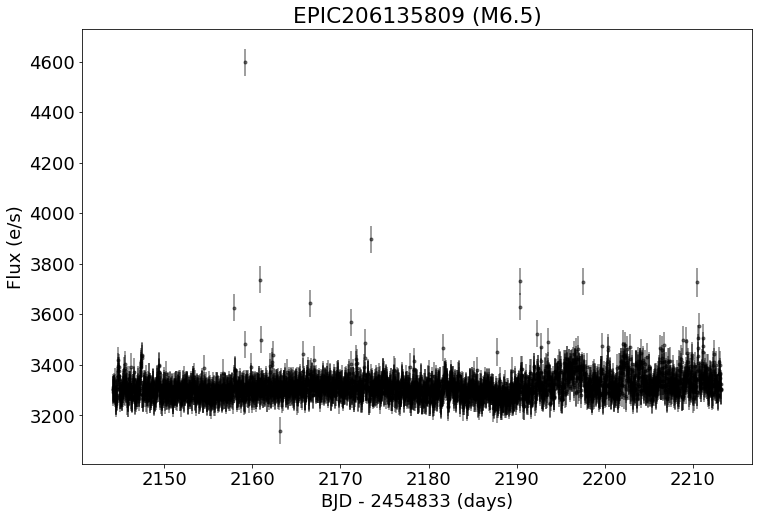

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)

# Plot the timeseries in black circles.
#ax.plot(k2_bjds, pdcsap_fluxes, 'ko')
ax.errorbar(k2_bjds, pdcsap_fluxes, 
             yerr=pdcsap_fluxes_err*10, fmt='.', color='k', alpha=0.5)

ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (M6.5)')
plt.savefig('Figures/EPIC206135809_lc.png')

In [6]:
#Filtering nans from data
flux = pdcsap_fluxes[(~np.isnan(pdcsap_fluxes)) & (~np.isnan(k2_bjds))][:500]
flux1 = flux.copy()
#pdcsap_fluxes[np.where(np.isnan(pdcsap_fluxes) == False)[0]]
fluxerr = pdcsap_fluxes_err[np.where(np.isnan(pdcsap_fluxes_err) == False)[0]][:500]
bjd = k2_bjds[np.where((np.isnan(k2_bjds) == False) & (np.isnan(pdcsap_fluxes) == False))[0]][:500]

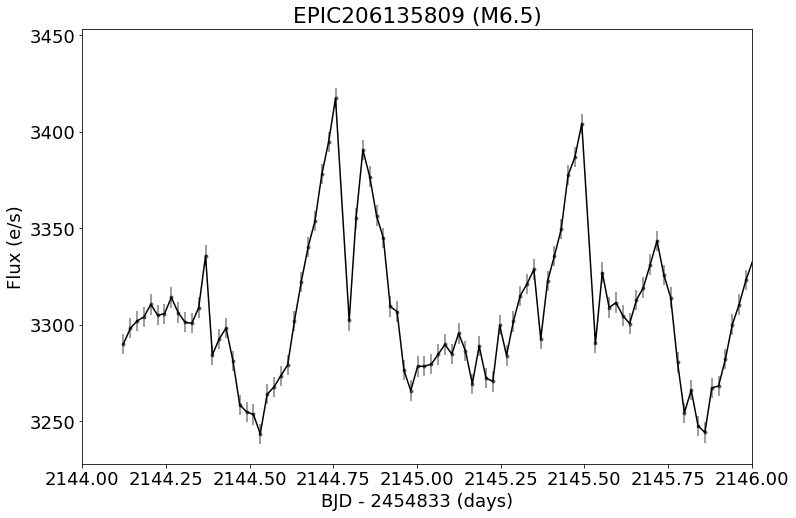

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)
plt.errorbar(bjd, flux, yerr=fluxerr, fmt='k.',alpha=0.5)
plt.plot(bjd, flux, c='k')
ax.set_xlim(2144,2146)
ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (M6.5)')

plt.savefig('Figures/EPIC206135809_lc_red.png')

In [8]:
dt = np.diff(bjd)

In [63]:
def invgaussian(m, s, x):
    g = -np.exp(-(m-x)**2 / s**2) + 1 
    return g

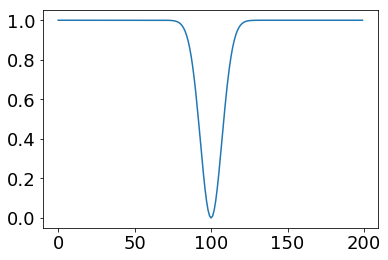

In [64]:
plt.plot(invgaussian(0, 1, np.arange(-10,10, 0.1)))

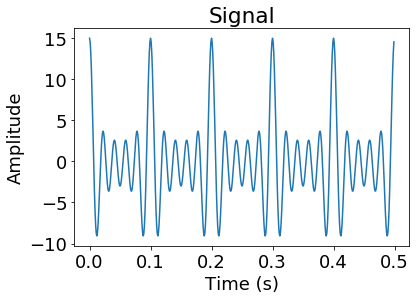

In [11]:
x = np.arange(0, 0.5, 0.001)
w = 2*10*np.pi
fluxtest = np.sum(n*np.cos(n*w*x) for n in range(1,6))
plt.plot(x, fluxtest)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Signal')
plt.savefig('Signal', bbox_inches='tight', dpi=300)
plt.show()

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


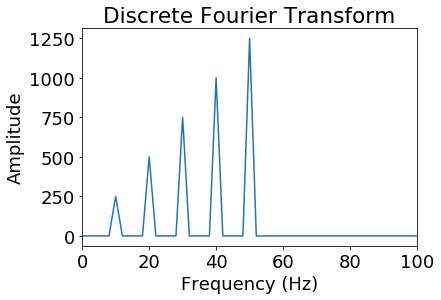

In [12]:
spectrum = np.fft.rfft(fluxtest)
freqs = np.fft.rfftfreq(len(fluxtest),0.001)
plt.plot(freqs, spectrum)
plt.title("Discrete Fourier Transform")
plt.xlim(0,100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.savefig('discfft', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
np.diff(x)[0]

0.001

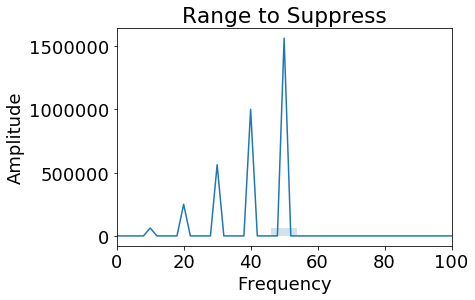

In [14]:
freq = np.fft.rfftfreq(len(fluxtest), np.diff(x)[0])
    
Low_cutoff, High_cutoff = 45, 55
ps = np.abs(spectrum)**2
plt.plot(freq, ps)
seg = (freq)[(np.abs(freq) > Low_cutoff) & 
                        (np.abs(freq) < High_cutoff)]
plt.fill_between(seg, [0]*len(seg), [60000]*len(seg), alpha=0.2)
plt.xlim(0,100)
plt.title('Range to Suppress')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

## Gaussian Filter on Sine Model

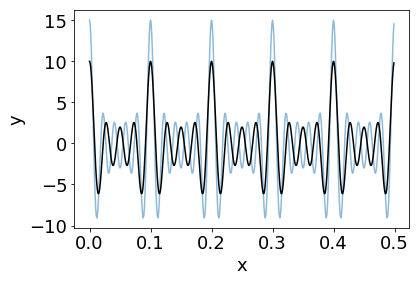

In [15]:
#judst set to 0
spectrum1 = spectrum.copy()
spectrum1[np.array([f in seg for f in freq])] = 0
plt.plot(x, fluxtest, alpha=0.5)
plt.plot(x, np.fft.irfft(spectrum1), 'k')
plt.xlabel('x')
plt.ylabel('y')

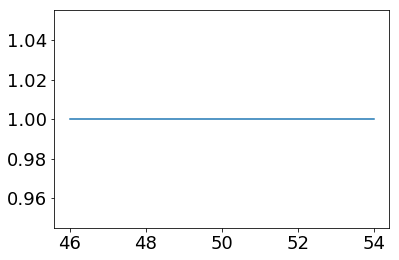

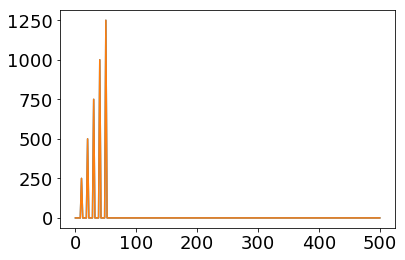

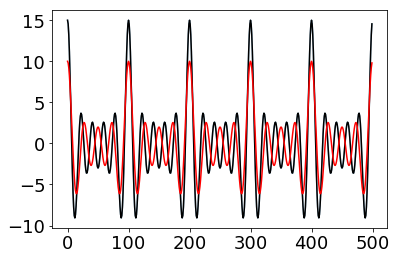

In [16]:
#just set to 0
spectrum2 = spectrum.copy()
spectrum2[np.array([f in seg for f in freq])] *= invgaussian(1.75, 0.2, seg)
plt.plot(seg, invgaussian(1.75, 0.1, seg))
plt.figure()
plt.plot(freq, np.abs(spectrum))
plt.plot(freq, np.abs(spectrum2))
plt.figure()
plt.plot(fluxtest, alpha=0.5)
plt.plot(np.fft.irfft(spectrum2), 'k')
plt.plot(np.fft.irfft(spectrum1), 'r')


## Main filtering function 

In [61]:
#Some borrowed code (from http://forrestbao.blogspot.com/2014/07/signal-filtering-using-inverse-fft-in.html)
#that does the FFT filtering with scipy:

def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, M=None, inv_box=False, gf_sig = 1, Filter='box'):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    plt.plot(freq, ps)
    plt.title("power spectrum")
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Power Spectral Density')
    #plt.xlim(0,100)
    plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
    plt.figure()
    
    plt.plot(freq, spectrum)
    #plt.plot(freq[between], spectrum[between], alpha=0.5)
    plt.title("real fourier transform ")
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Amplitude')
    #plt.xlim(0,100)
    plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
    plt.figure()
    
    
    
    if Filter == 'box':
    
        filtered_spectrum = spectrum.copy()
    
        if inv_box == True:
            x_1 = np.arange(0, Low_cutoff, 0.1)
            x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
            plt.plot(freq, spectrum)
            plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
            plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
            plt.title("range to suppress")
            plt.figure()
            filtered_spectrum[lc] = 0.
            filtered_spectrum[hc] = 0.
        else:
            x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
            plt.plot(freq, spectrum)
            plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
            plt.title("range to suppress")
            plt.figure()
            filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
        ig = invgaussian(np.median([low_cutoff,high_cutoff]), gf_sig, freq)
        filtered_spectrum = spectrum * ig
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()
        
    
    plt.plot(freq, filtered_spectrum, label="filtered spectrum")
    plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
    plt.title("Unfiltered vs. Filtered Spectrum")
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Amplitude')
    ldg = plt.legend(fontsize=12)
    #plt.xlim(0,100)
    plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
    plt.figure()
    
    
    fig = plt.figure(figsize=(15,10))
    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal
    print(len(flux),len(freq), len(filtered_signal))
    plt.plot(t, filtered_signal, label="filtered signal")
    plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title("Unfiltered vs. Filtered Signal")
    plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
    plt.legend()
    #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

## Testing on simple model

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


500 251 500


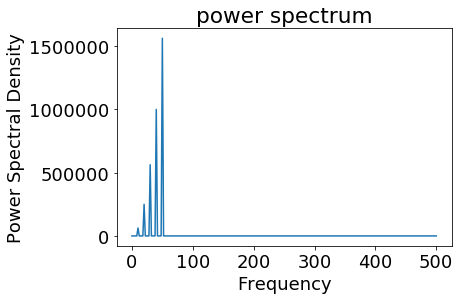

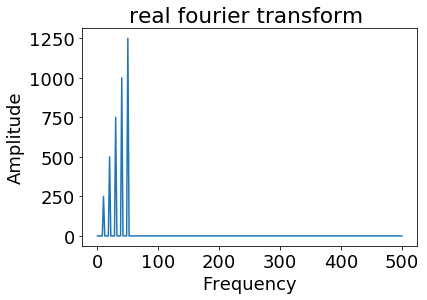

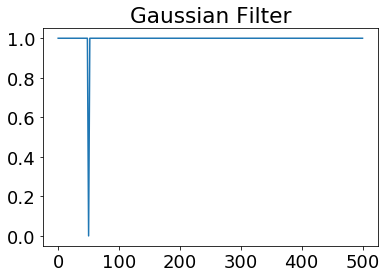

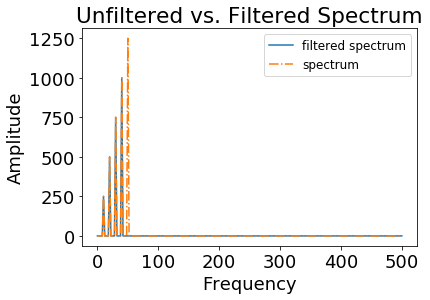

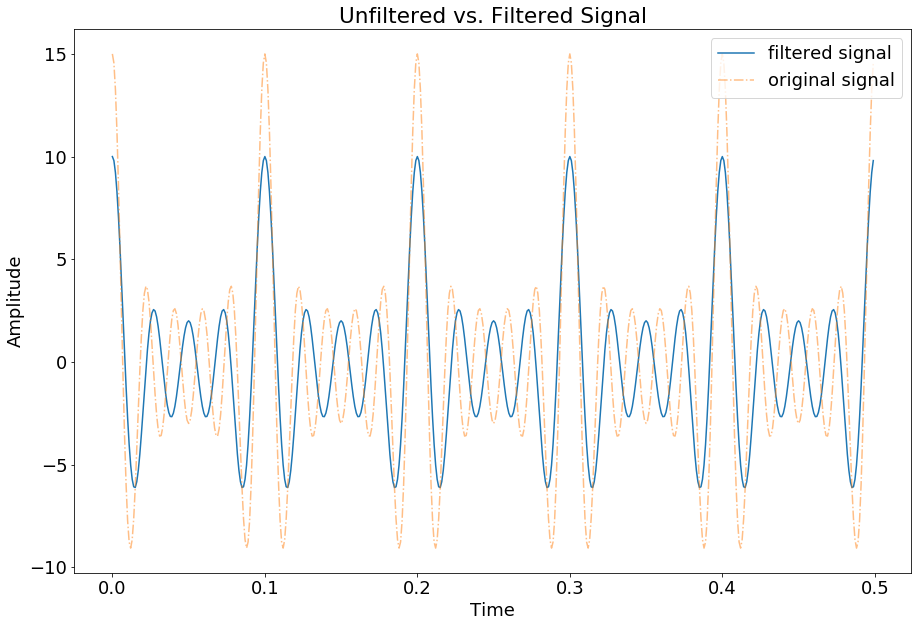

In [18]:
Low_cutoff, High_cutoff, F_sample = 45, 55, np.diff(x)[0]

Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(x, fluxtest, 
                                                        Low_cutoff, High_cutoff, F_sample, 
                                                        gf_sig = 0.5, Filter='Gaussian')

## Gaussian Filter on K2 Lightcurve

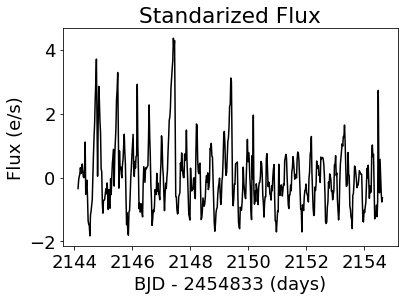

In [19]:
## Standarize data
fluxnorm = (flux - np.mean(flux)) / np.std(flux)
plt.plot(bjd, fluxnorm, c='k')
plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")
plt.title("Standarized Flux")
plt.savefig('Figures/std-flux.png', bbox_inches='tight', pad_inches=0.5)

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


500 251 500


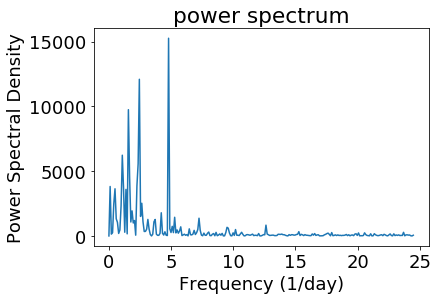

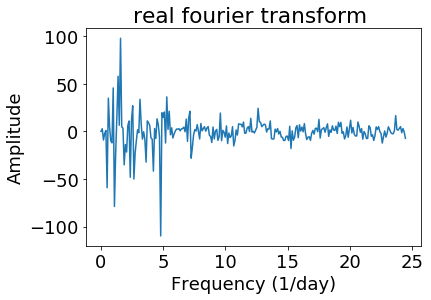

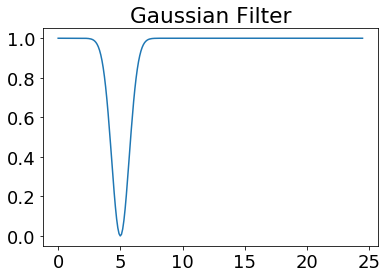

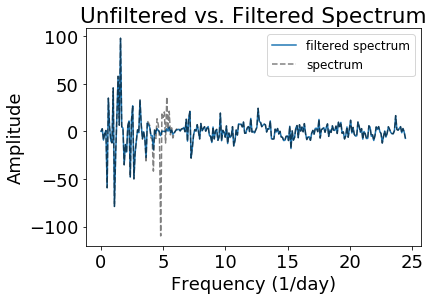

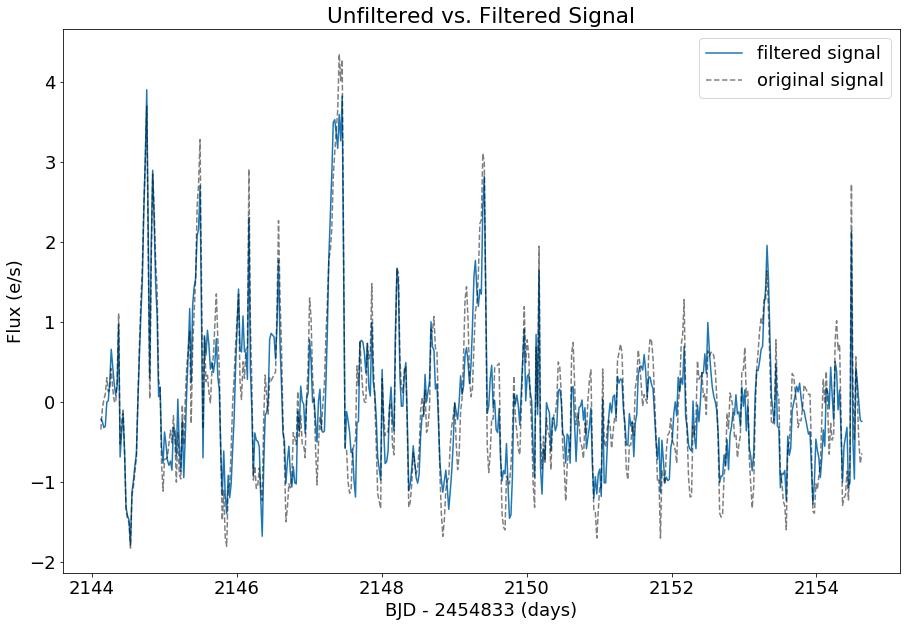

In [29]:
Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjd)[0]
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjd, fluxnorm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')


plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")

plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)

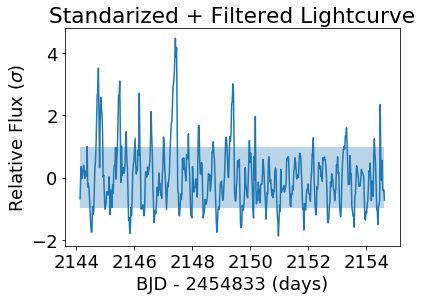

In [178]:
plt.plot(bjd, Filtered_signal)
plt.fill_between(bjd, np.mean(Filtered_signal)+np.std(Filtered_signal), 
                 np.mean(Filtered_signal)-np.std(Filtered_signal), alpha=0.3)
plt.xlabel("BJD - 2454833 (days)")
plt.ylabel(r"Relative Flux $(\sigma)$")
plt.title("Standarized + Filtered Lightcurve")

In [26]:
fits_1 = "https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/35000/ktwo206135809-c03_llc.fits"
fits_2 = "https://archive.stsci.edu/missions/k2/lightcurves/c3/206000000/50000/ktwo206050032-c03_llc.fits"
fits_3 = "https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/53000/ktwo206153008-c03_llc.fits"
fits_4 = "https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/58000/ktwo206158769-c03_llc.fits"
fits_5 = "https://archive.stsci.edu/missions/k2/lightcurves/c3/206000000/03000/ktwo206003031-c03_llc.fits"

In [27]:
with fits.open(fits_1, mode="readonly") as hdulist:
    k2_bjds1 = hdulist[1].data['TIME']
    sap_fluxes1 = hdulist[1].data['SAP_FLUX']
    sap_errors1 = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes1 = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err1 = hdulist[1].data['PDCSAP_FLUX_ERR']
    
with fits.open(fits_2, mode="readonly") as hdulist:
    k2_bjds2 = hdulist[1].data['TIME']
    sap_fluxes2 = hdulist[1].data['SAP_FLUX']
    sap_errors2 = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes2 = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err2 = hdulist[1].data['PDCSAP_FLUX_ERR']

with fits.open(fits_3, mode="readonly") as hdulist:
    k2_bjds3 = hdulist[1].data['TIME']
    sap_fluxes3 = hdulist[1].data['SAP_FLUX']
    sap_errors3 = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes3 = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err3 = hdulist[1].data['PDCSAP_FLUX_ERR']
    
with fits.open(fits_4, mode="readonly") as hdulist:
    k2_bjds4 = hdulist[1].data['TIME']
    sap_fluxes4 = hdulist[1].data['SAP_FLUX']
    sap_errors4 = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes4 = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err4 = hdulist[1].data['PDCSAP_FLUX_ERR']
    
with fits.open(fits_5, mode="readonly") as hdulist:
    k2_bjds5 = hdulist[1].data['TIME']
    sap_fluxes5 = hdulist[1].data['SAP_FLUX']
    sap_errors5 = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes5 = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err5 = hdulist[1].data['PDCSAP_FLUX_ERR']

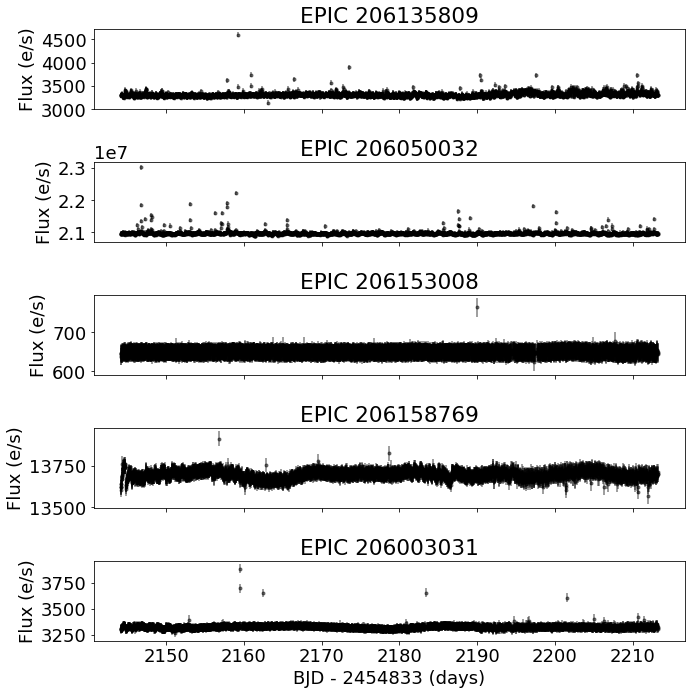

In [51]:
fig, axs = plt.subplots(5)
fig.set_size_inches(10., 10.)

axs[0].errorbar(k2_bjds1, pdcsap_fluxes1, 
             yerr=pdcsap_fluxes_err1*10, fmt='.', color='k', alpha=0.5)
axs[0].set_title('EPIC 206135809')

axs[1].errorbar(k2_bjds2, pdcsap_fluxes2, 
             yerr=pdcsap_fluxes_err2*10, fmt='.', color='k', alpha=0.5)
axs[1].set_title('EPIC 206050032')

axs[2].errorbar(k2_bjds3, pdcsap_fluxes3, 
             yerr=pdcsap_fluxes_err3*10, fmt='.', color='k', alpha=0.5)
axs[2].set_title('EPIC 206153008')

axs[3].errorbar(k2_bjds4, pdcsap_fluxes4, 
             yerr=pdcsap_fluxes_err4*10, fmt='.', color='k', alpha=0.5)
axs[3].set_title('EPIC 206158769')

axs[4].errorbar(k2_bjds5, pdcsap_fluxes5, 
             yerr=pdcsap_fluxes_err5*10, fmt='.', color='k', alpha=0.5)
axs[4].set_title('EPIC 206003031')

for ax in axs:
    ax.set_ylabel("Flux (e/s)")
    ax.label_outer()
axs[4].set_xlabel("BJD - 2454833 (days)")
plt.tight_layout()

In [53]:
flux1 = pdcsap_fluxes1[(~np.isnan(pdcsap_fluxes1)) & (~np.isnan(k2_bjds1))][:500]
fluxerr1 = pdcsap_fluxes_err1[np.where(np.isnan(pdcsap_fluxes_err1) == False)[0]][:500]
bjd1 = k2_bjds1[np.where((np.isnan(k2_bjds1) == False) & (np.isnan(pdcsap_fluxes1) == False))[0]][:500]

flux2 = pdcsap_fluxes2[(~np.isnan(pdcsap_fluxes2)) & (~np.isnan(k2_bjds2))][:500]
fluxerr2 = pdcsap_fluxes_err2[np.where(np.isnan(pdcsap_fluxes_err2) == False)[0]][:500]
bjd2 = k2_bjds2[np.where((np.isnan(k2_bjds2) == False) & (np.isnan(pdcsap_fluxes2) == False))[0]][:500]

flux3 = pdcsap_fluxes3[(~np.isnan(pdcsap_fluxes3)) & (~np.isnan(k2_bjds3))][:500]
fluxerr3 = pdcsap_fluxes_err3[np.where(np.isnan(pdcsap_fluxes_err3) == False)[0]][:500]
bjd3 = k2_bjds3[np.where((np.isnan(k2_bjds3) == False) & (np.isnan(pdcsap_fluxes3) == False))[0]][:500]

flux4 = pdcsap_fluxes4[(~np.isnan(pdcsap_fluxes4)) & (~np.isnan(k2_bjds4))][:500]
fluxerr4 = pdcsap_fluxes_err4[np.where(np.isnan(pdcsap_fluxes_err4) == False)[0]][:500]
bjd4 = k2_bjds4[np.where((np.isnan(k2_bjds4) == False) & (np.isnan(pdcsap_fluxes4) == False))[0]][:500]

flux5 = pdcsap_fluxes5[(~np.isnan(pdcsap_fluxes5)) & (~np.isnan(k2_bjds5))][:500]
fluxerr5 = pdcsap_fluxes_err5[np.where(np.isnan(pdcsap_fluxes_err5) == False)[0]][:500]
bjd5 = k2_bjds5[np.where((np.isnan(k2_bjds5) == False) & (np.isnan(pdcsap_fluxes5) == False))[0]][:500]

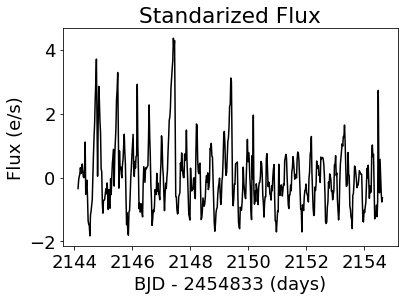

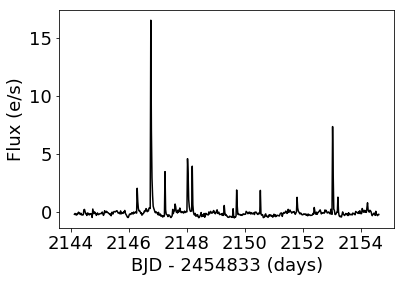

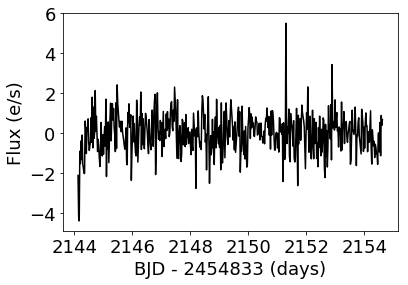

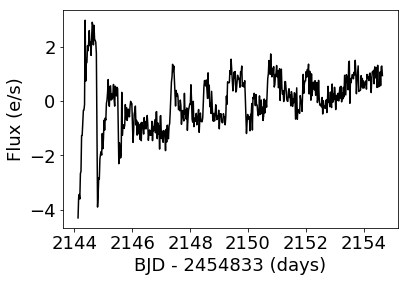

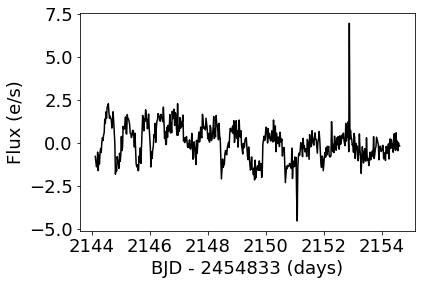

In [58]:
fluxnorm1 = (flux1 - np.mean(flux1)) / np.std(flux1)
plt.plot(bjd1, fluxnorm1, c='k')
plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")
plt.title("Standarized Flux")
plt.show()

fluxnorm2 = (flux2 - np.mean(flux2)) / np.std(flux2)
plt.plot(bjd2, fluxnorm2, c='k')
plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")
plt.show()

fluxnorm3 = (flux3 - np.mean(flux3)) / np.std(flux3)
plt.plot(bjd3, fluxnorm3, c='k')
plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")
plt.show()

fluxnorm4 = (flux4 - np.mean(flux4)) / np.std(flux4)
plt.plot(bjd4, fluxnorm4, c='k')
plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")
plt.show()

fluxnorm5 = (flux5 - np.mean(flux5)) / np.std(flux5)
plt.plot(bjd5, fluxnorm5, c='k')
plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")
plt.show()

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


500 251 500


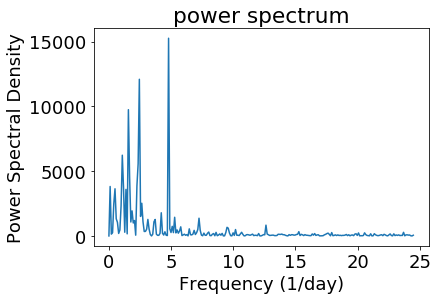

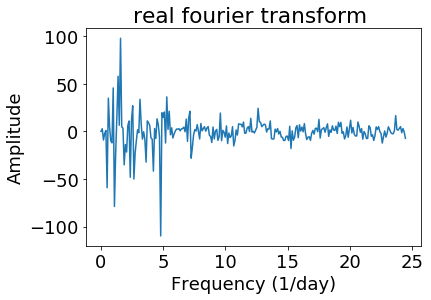

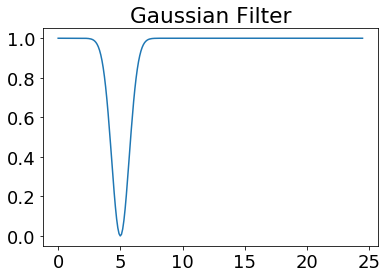

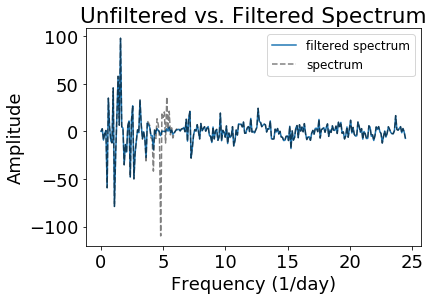

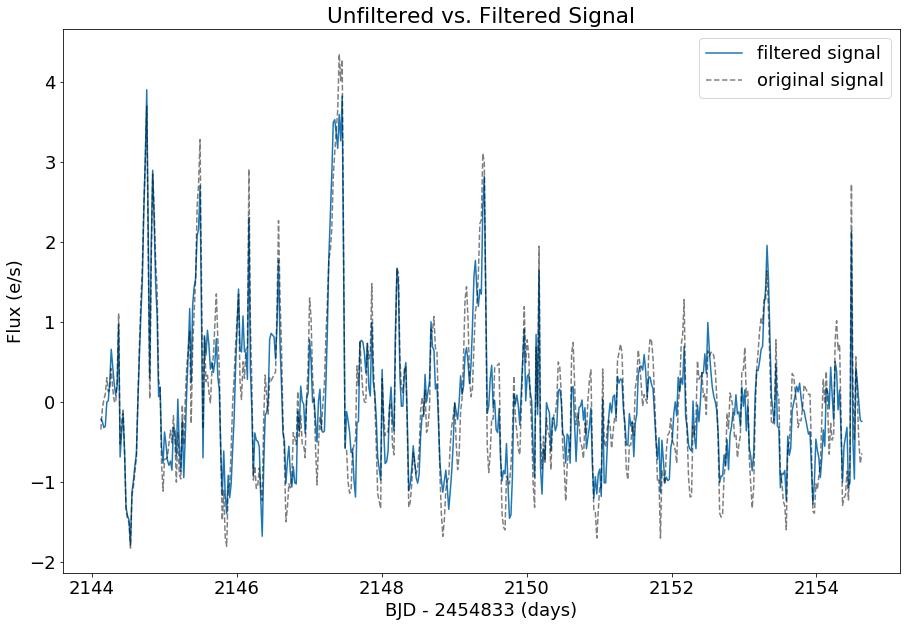

In [66]:
Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjd1)[0]
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjd1, fluxnorm1, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')


plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")



/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


500 251 500


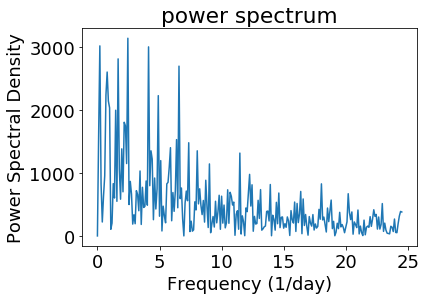

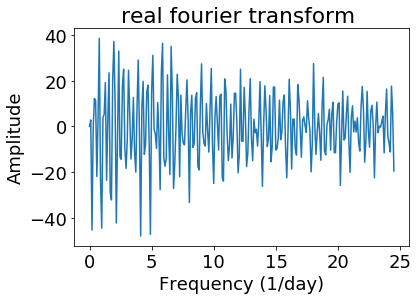

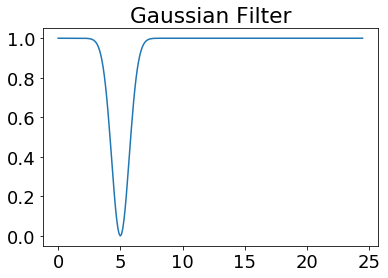

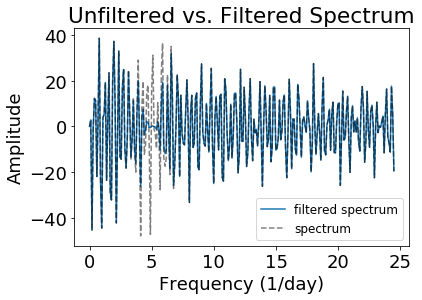

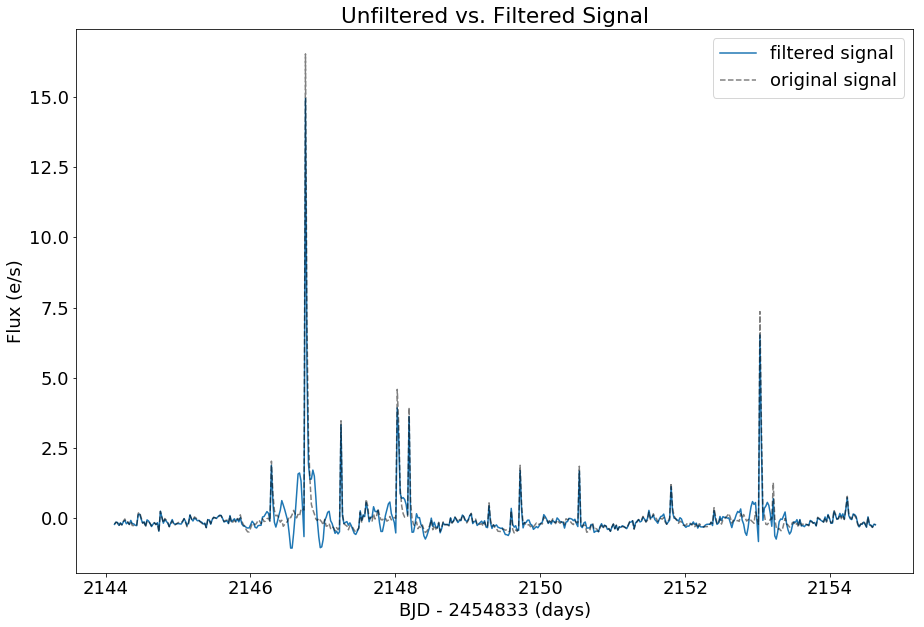

In [67]:
Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjd2)[0]
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjd2, fluxnorm2, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')


plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


500 251 500


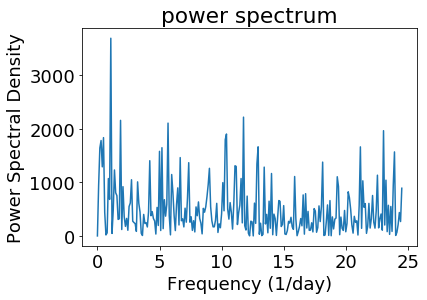

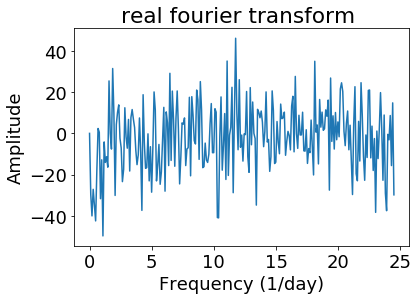

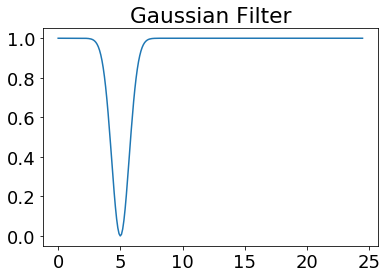

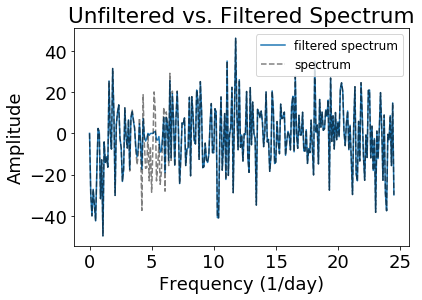

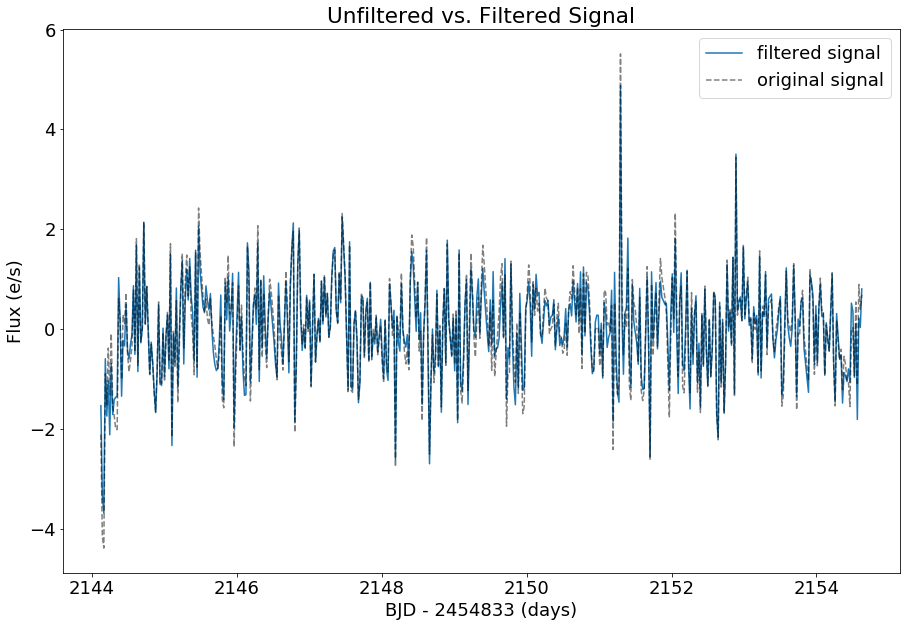

In [68]:
Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjd3)[0]
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjd3, fluxnorm3, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')


plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


500 251 500


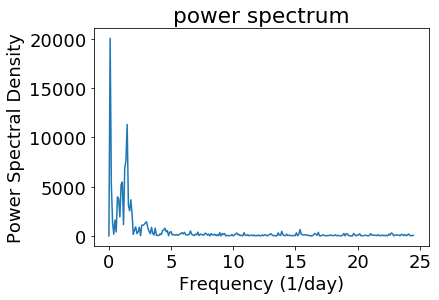

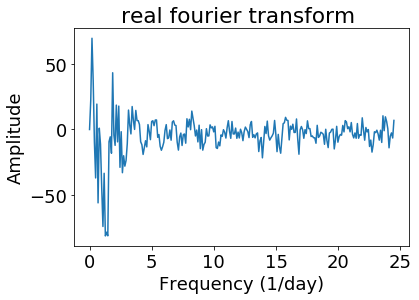

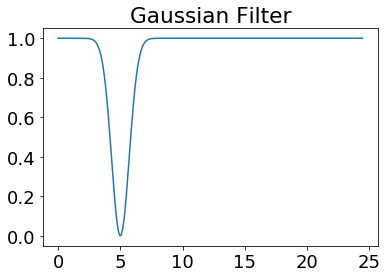

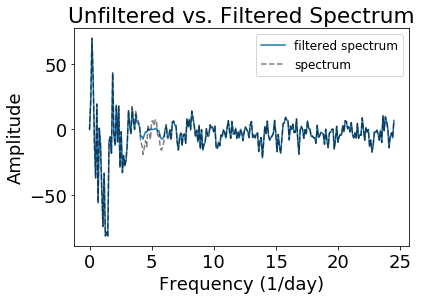

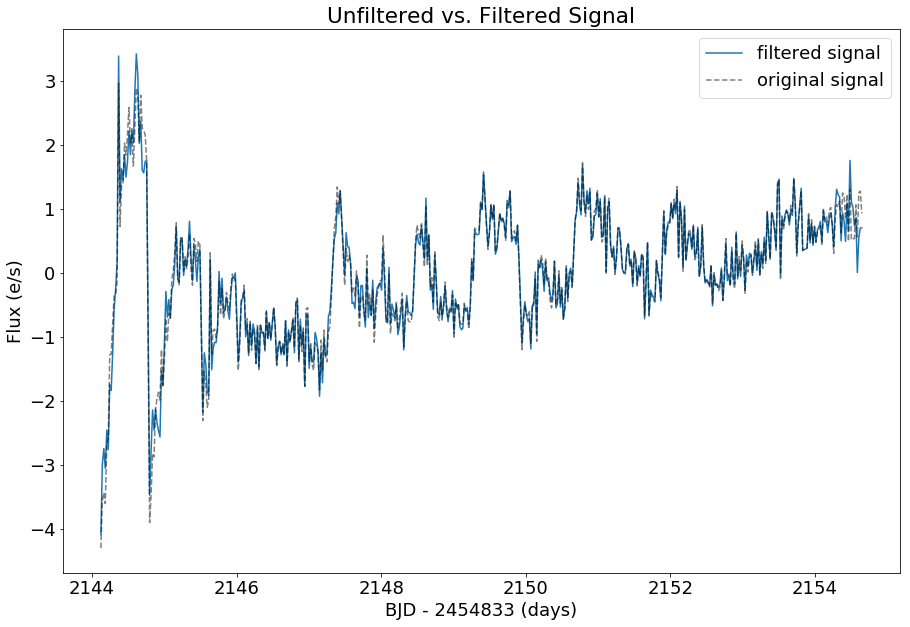

In [69]:
Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjd4)[0]
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjd4, fluxnorm4, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')


plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


500 251 500


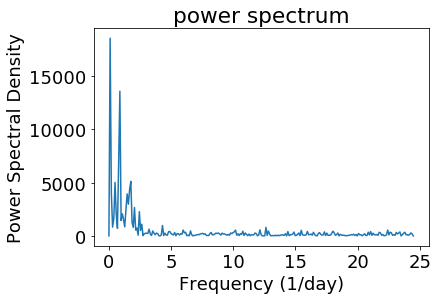

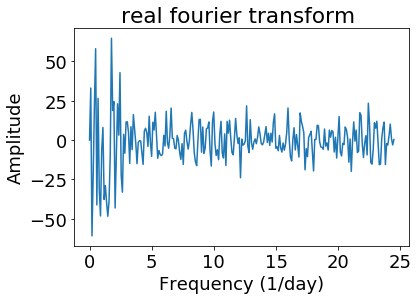

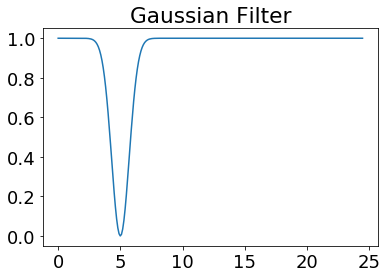

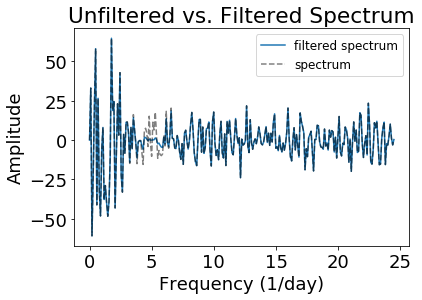

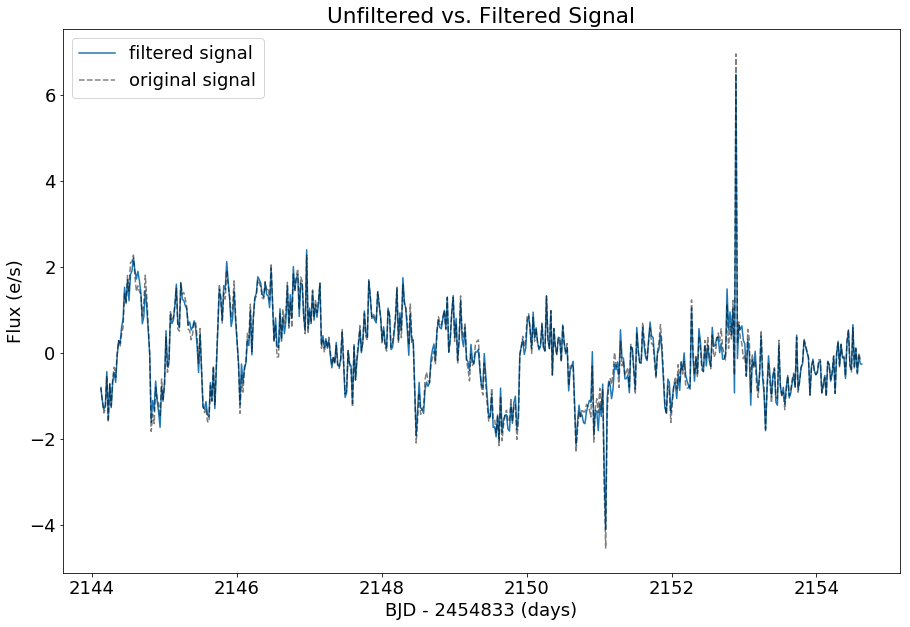

In [70]:
Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjd5)[0]
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjd5, fluxnorm5, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')


plt.ylabel("Flux (e/s)")
plt.xlabel("BJD - 2454833 (days)")

------------

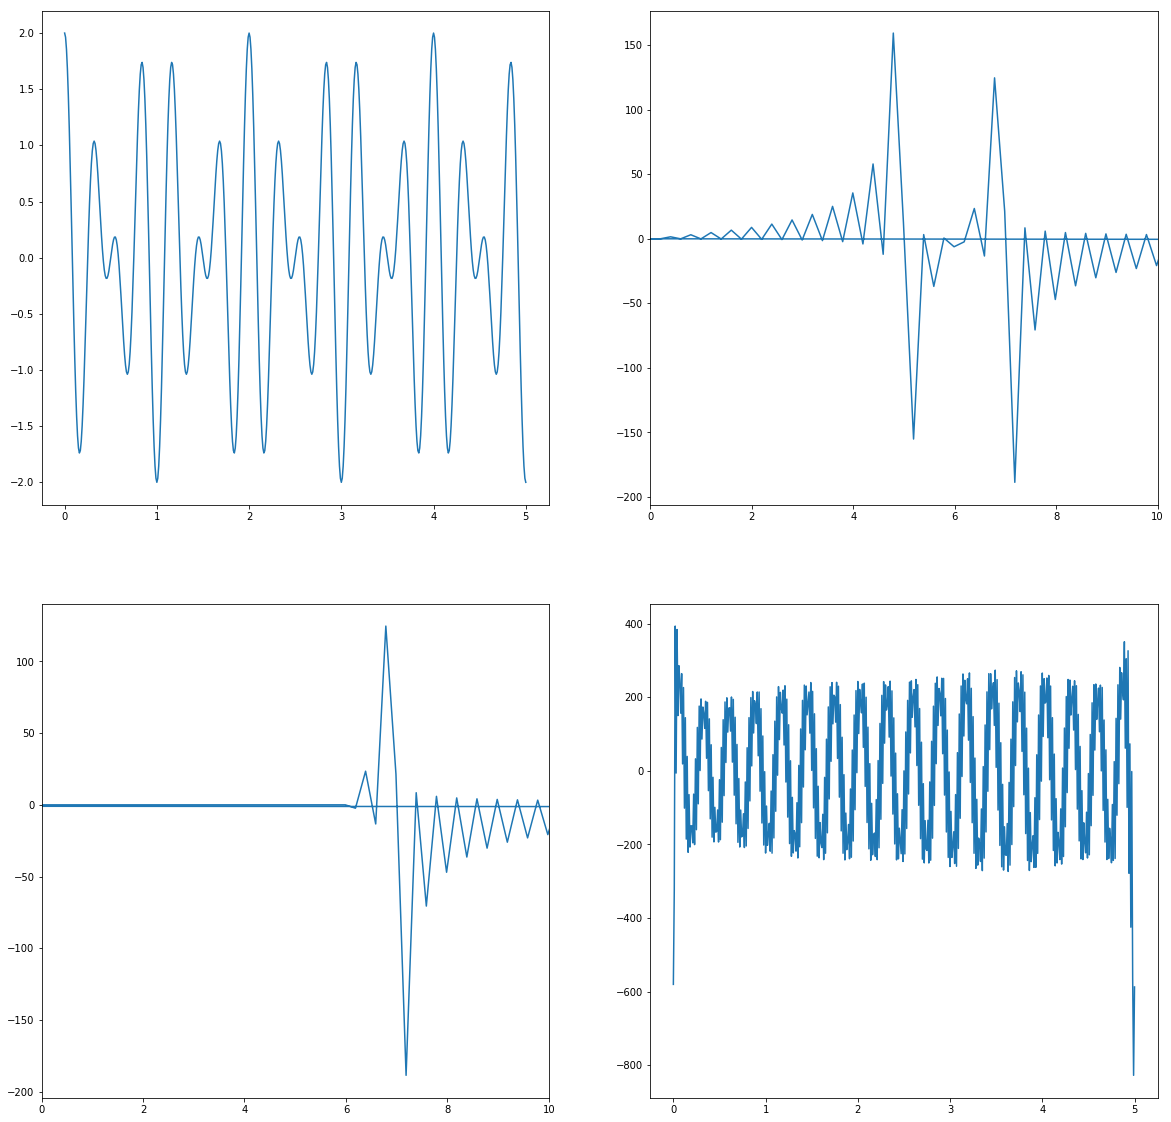

In [127]:

from scipy.fftpack import rfft, irfft, fftfreq
time   = np.linspace(0,5,501)
signal = np.cos(5*np.pi*time) + np.cos(7*np.pi*time)

W =  np.fft.fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[W<6] = 0

cut_signal = rfft(cut_f_signal)
#We can plot the evolution of the signal in real and fourier space:

import pylab as plt
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(time, signal)
plt.subplot(222)
plt.plot(W, f_signal)
plt.xlim(0,10)
plt.subplot(223)
plt.plot(W, cut_f_signal)
plt.xlim(0,10)
plt.subplot(224)
plt.plot(time,cut_signal)
plt.show()

[3294.82711187+1.29620257j 3300.48989363+1.56911513j
 3303.28216187+0.51980236j 3305.74509517-0.40286956j
 3313.2406125 -0.28210819j 3308.32819152+0.81088348j
 3308.87231093+2.14496027j 3316.56412162+3.09458694j
 3307.90939824+3.66808063j 3302.2552957 +4.34317802j]


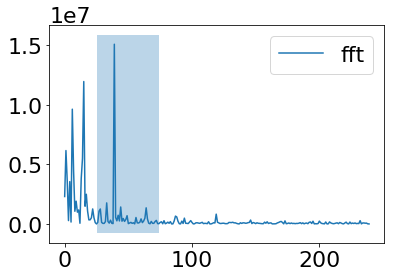

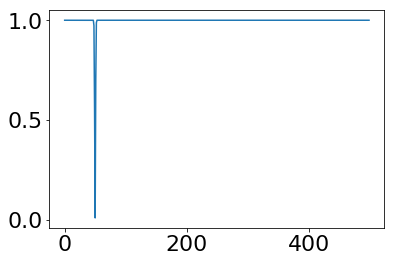

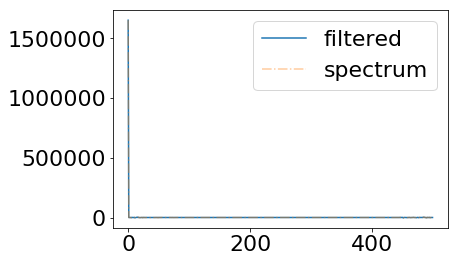

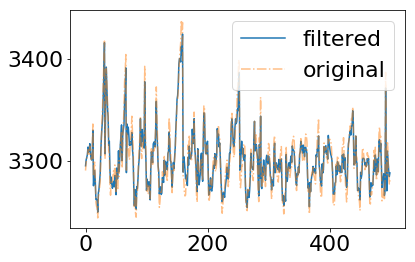

In [51]:
Low_cutoff, High_cutoff, F_sample = 25, 75, 500
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(flux, Low_cutoff, High_cutoff, 
                                                                                    F_sample, M=len(bjd), inv=True)

Add inv gaussian filter:
   - mu = bin(freq_telescope)
   - sigma
   - 1 - g(mu, sigma)

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


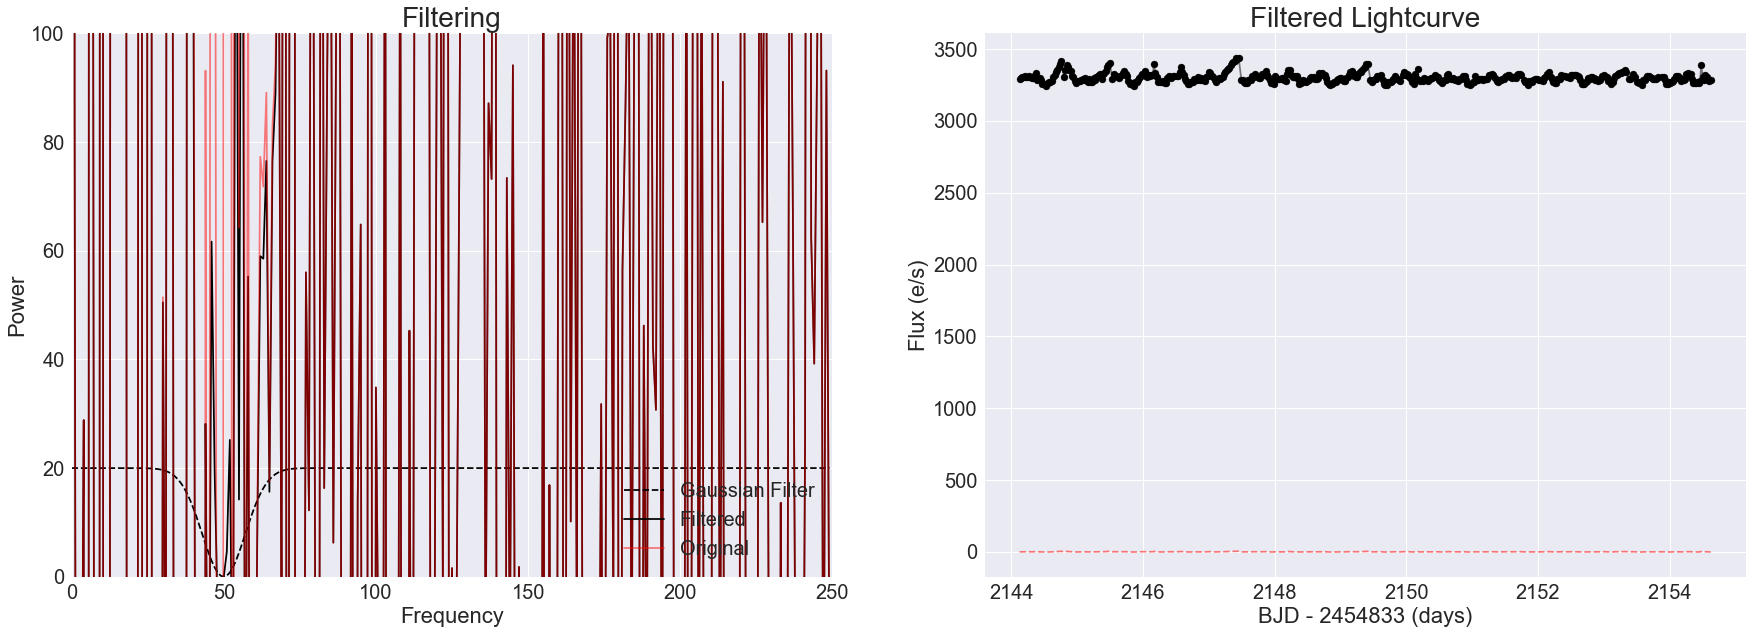

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = np.ravel(axs)
plt.rcParams.update({'font.size': 36})

axs[0].set_title('Filtering',fontsize=28)
axs[1].set_title('Filtered Lightcurve',fontsize=28)

axs[0].set_xlim(0,F_sample/2)
axs[0].set_ylim(0,100)

axs[0].set_xlabel('Frequency',fontsize=22)
axs[0].set_ylabel('Power',fontsize=22)

axs[1].set_xlabel('BJD - 2454833 (days)',fontsize=22)
axs[1].set_ylabel('Flux (e/s)',fontsize=22)

axs[0].tick_params(labelsize=20)
axs[1].tick_params(labelsize=20)

m = 50
s = 10

axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, 
         invgaussian(m, s, np.fft.fftfreq(len(bjd))[:250]*F_sample)*20, c='k', ls='--', label='Gaussian Filter')
axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, 
         Spectrum[:250]*invgaussian(m, s, np.fft.fftfreq(len(bjd))[:250]*F_sample), c='k',label='Filtered')
axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, Spectrum[:250], c='r',label='Original', alpha=0.5)

#axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, abs(Spectrum[:250]), c='k')
#axs[0].axvspan(Low_cutoff, High_cutoff, color='red', alpha = 0.25)
#axs[0].axvspan(High_cutoff, 250, color='green', alpha = 0.25)
#axs[0].axvspan(-250,Low_cutoff, color='green', alpha = 0.25)
axs[1].scatter(bjd, Filtered_signal, color='k')
axs[1].plot(bjd, Filtered_signal, color='k',alpha=0.5)
axs[1].plot(bjd, (flux1 - flux1.mean()) / flux1.std(),'r--',alpha=0.5)

axs[0].legend(fontsize=20)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)
ax.errorbar(bjd, Filtered_signal, yerr=fluxerr*10, fmt='r.',alpha=0.5,label='Filtered')
ax.set_ylim(3000,3600)
ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (Filtered)')
ax.errorbar(bjd, flux, yerr=fluxerr*10, fmt='k.',alpha=0.5,label='Unfiltered')
#plt.savefig('Figures/EPIC206135809_lc.png')
plt.legend(fontsize=20)

In [ ]:
#Tweak bandpass to allow inverse window
#Run on whole code

In [ ]:
#Filtering nans from data
flux = pdcsap_fluxes[(~np.isnan(pdcsap_fluxes)) & (~np.isnan(k2_bjds))]#[:500]
#pdcsap_fluxes[np.where(np.isnan(pdcsap_fluxes) == False)[0]]
fluxerr = pdcsap_fluxes_err[np.where(np.isnan(pdcsap_fluxes_err) == False)[0]]#[:500]
bjd = k2_bjds[np.where((np.isnan(k2_bjds) == False) & (np.isnan(pdcsap_fluxes) == False))[0]]#[:500]

In [ ]:
Low_cutoff, High_cutoff, F_sample = 0, 50, 500
Spectrum, Filtered_spectrum, Filtered_signal, Low_point, High_point = bandpass_ifft(flux, Low_cutoff, High_cutoff, 
                                                                                    F_sample, M=len(bjd))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = np.ravel(axs)
plt.rcParams.update({'font.size': 36})

axs[0].set_title('Original Spectrum',fontsize=28)
axs[1].set_title('Filtered Lightcurve',fontsize=28)

axs[0].set_xlim(0,F_sample/2)
axs[0].set_ylim(0,20000)

axs[0].set_xlabel('Frequency',fontsize=22)
axs[0].set_ylabel('Power',fontsize=22)

axs[1].set_xlabel('BJD - 2454833 (days)',fontsize=22)
axs[1].set_ylabel('Flux (e/s)',fontsize=22)

axs[0].tick_params(labelsize=20)
axs[1].tick_params(labelsize=20)

axs[0].plot(np.fft.fftfreq(len(bjd))[:int(len(bjd)/2)]*F_sample, abs(Spectrum[:int(len(bjd)/2)]), c='k')
axs[0].axvspan(Low_cutoff, High_cutoff, color='green', alpha = 0.25)
axs[0].axvspan(High_cutoff, 250, color='red', alpha = 0.25)
axs[1].scatter(bjd, Filtered_signal, color='k')
axs[1].plot(bjd, Filtered_signal, color='k',alpha=0.5)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)
plt.errorbar(bjd, Filtered_signal, yerr=fluxerr*10, fmt='r.',alpha=0.5)
ax.set_ylim(3000,3600)
ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (Filtered)')
ax.errorbar(bjd, flux, yerr=fluxerr*10, fmt='k.',alpha=0.2)
#plt.savefig('Figures/EPIC206135809_lc.png')